## **PyTorch Transfer Learning**

#### What is transfer learning?

Transfer learning allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.

Like, we could take the patterns from a language model, and use them as the basis of a model to classify different text samples.

#### Why use transfer learning?

There are two main benefits to using transfer learning:

1. Can leverage an existing model proven to work on problems similar to our own.

2. Can leverage a working model which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.


We will tackle our previous food vision model, which performed poorly on our tests.

### Where to find pretrained models?

1. PyTorch domain libraries
2. Hugging Face Hub
3. `timm` (PyTorch Image Models library)
4. Papers with Code


In [1]:
%pip install torch torchvision torchaudio

/home/monitsharma/parallel_adventures/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [2]:

import os
import torch
from torch import nn
import matplotlib.pyplot as plt

# let's see the pytorch version
torch.__version__

'2.7.1+cu126'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Setup

In [4]:
# you can change the updated versions as well
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
torch version: 2.7.1+cu126
torchvision version: 0.22.1+cu126


In [6]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo, so installing it now")
  %pip install -q torchinfo
  from torchinfo import summary

try:
  from going_modular import data_setup, engine
except:
  print("[INFO] Couldn't find going_modular, so downloading them")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular import data_setup, engine

# they will be , since we made them in the previous notebook




/home/monitsharma/parallel_adventures/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Getting Data**


Before we start with transfer learning, we'll need a dataset, here we will deal with the `pizza_steak_sushi` comparison

In [7]:
import os
import zipfile

from pathlib import Path
import requests

data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)


  # download
  with open(data_path/"pizza_steak_sushi.zip","wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

    # unzip them
  with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)


  # remove the zip file
  os.remove(data_path/"pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


Let's make trainig and testing path

In [8]:
train_dir = image_path/"train"
test_dir = image_path/"test"

### Create Datasets and DataLoaders

We can make use of our `data_setup.py` file, so we can direclty make use of it. But since we are going to use a pretrained model from `torchvision.models`, there's a specific transform that we need to prepare our images first

When using a pretrained model, it is important that our custom data going into the model is prepared with the same way as the original training data that went into the model.

All pre-trained models expect the input images normalized in the same wau, i.e mini-batches of 3-channels RGB images of shape (3 X H X W) , where H and W are expected to be at least 224.


The images have to be loaded in to a range of [0,1], and then normalized using `mean=[0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`


So we will make use of

```Python
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
```


Some pretrained models from `torchvision.models` in different sizes to [3,224,224]`

In [9]:
manual_transfomrms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

Since, we have manually created series of transforms ready to prepare our images.  let's create training and testing DataLoaders.



In [10]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform= manual_transfomrms,
                                                                               batch_size =32)

train_dataloader, test_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x70adf1f0ed10>,
 ['pizza', 'steak', 'sushi'])

#### Creating a transform for `torchvision.models`


When using pretrained model, it's important that our custom data going into the model is prepared in the same way as the original training data that went into the model.

There is also a new feature for automatic transform creation.


When we setup a model from `torchvision.models` and select a pretrained model weight, we like to use

```python
weights = torchvision.models.EfficientNet_B0-Weights.DEFAULT
```

Where:

- `EfficientNet_B0_Weights` is the model architecture weights we'd like to use
- `DEFAULT` means the best available weights

In [11]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

And, now to access the transforms associated with our `weights`, we can make use of the `transforms()` method

In [12]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

This is essentially saying "Get the data transforms that were used to train the `EfficientNet_B0_Weights`". It is very similar to `manual_transforms`, the only difference is that `auto_transform` came with the model architecture we chose, where as we had to create `manual_transforms` from scratch.



In [13]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                                 batch_size=32)



train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x70adf1d3e390>,
 ['pizza', 'steak', 'sushi'])

## **Getting a Pre-Trained Model**

The whole idea of transfer learning is to take an already well-performing model on a problem space similar to ours and then customize it to our use case.

#### Which model to use?

It depends on the problem and the device we are working with. Generally a higher number in the model name means better performance but a larger model.
Some better performing models are too big for some devices.


#### Setting up a pretrained model

The pre trained model we are going to use here will be `torchvision.models.efficient_b0()`

We can setup the `Efficientnet_B0` pretrained image net weights using the smae code we used to create the transformers

```python
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
```

This means the model has already been trained on millions of images and has a goof base representation of image data.

In [14]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# this means the model has already been trained on millions of images and has a good base representation of image data.
model = torchvision.models.efficientnet_b0(weights=weights).to(device)


model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/monitsharma/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 22.6MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

It is a very big model, with lots and lots of layers. This is one of the benefits of transfer learning, taking an existing model and applying to our problem. The `efficient_b0` comes in three main parts:

1. `features` - A collection of convolutional layers and other various activation layers to learn a base representation of vison data, the base layer of the model learn the different features of the image.

2. `avgpool` - Takes the average of the output of the `feature` layer and turn it into a feature vector.

3. `classifier` - Turns the feature vector into a vector with same dimensionality as the number of required output classes.

### Getting a summary of our model


To get this, we will pass in :
- `model` - the model we'd like to get a summary of
- `input_size` - the shape of the data we'd like to pass to our model
- `col_nanes` - the various information columns, we'd like to see about our model.
- `col_width` - How wide the columns should be for summary
- `row_settings` - what features to show in a row

In [15]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

Our previous model has `8083` parameters, this one has `5,288,548` parameters, an increase of `654x`

### Freezing the base model and changing the output layer to suit our needs

The process usually goes: freeze some base layers of a pretrained model (typically the `features` section) and then adjust the output layers to suit our needs
This model right now has `1000` out features, but we are only dealing with `3`. Let's freeze all of the layers/parameters in the `feature` section of our `efficientnet_b0` model.


Freezing means to keep them how they are during training, for example, if our model has pretrained layers, to freeze them would be to say "don't change any of the patterns in these layers during training, keep them how they are"


We can freeze all of the layers in `features` section by setting the attribute `requires_grad=False`, Pytorch doesn't track gradient updates and in turn, these parameters, won't be changed by our optimizer during training.


In [16]:
for param in model.features.parameters():
    param.requires_grad = False

Let's now adjust the output layer in the `classifier` portion

In [17]:
torch.manual_seed(135)
torch.cuda.manual_seed(135)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=output_shape, bias=True)).to(device)

So now we have updated our model. let's see the structure

In [18]:
summary(model, input_size=(32, 3, 224, 224),
        verbose=0,
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Train Model

Let's create a loss function and an optimizer

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

In [42]:
torch.manual_seed(135)
torch.cuda.manual_seed(135)

from timeit import default_timer as timer
start_time = timer()    

results = engine.train(model=model,
                          train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            epochs=10,
                            device=device)


end_time = timer()

print(f"[INFO] Training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [00:01<00:11,  1.32s/it]

Epoch: 1 | train_loss: 0.0023 | train_acc: 1.0000 | test_loss: 1.1623 | test_acc: 0.8456


 20%|██        | 2/10 [00:02<00:09,  1.21s/it]

Epoch: 2 | train_loss: 0.0058 | train_acc: 0.9961 | test_loss: 1.2753 | test_acc: 0.8049


 30%|███       | 3/10 [00:03<00:08,  1.14s/it]

Epoch: 3 | train_loss: 0.0093 | train_acc: 0.9961 | test_loss: 1.1051 | test_acc: 0.8352


 40%|████      | 4/10 [00:04<00:06,  1.10s/it]

Epoch: 4 | train_loss: 0.0511 | train_acc: 0.9883 | test_loss: 1.0856 | test_acc: 0.7737


 50%|█████     | 5/10 [00:05<00:05,  1.09s/it]

Epoch: 5 | train_loss: 0.0020 | train_acc: 1.0000 | test_loss: 1.1049 | test_acc: 0.8049


 60%|██████    | 6/10 [00:06<00:04,  1.08s/it]

Epoch: 6 | train_loss: 0.0221 | train_acc: 0.9922 | test_loss: 1.2619 | test_acc: 0.8049


 70%|███████   | 7/10 [00:07<00:03,  1.08s/it]

Epoch: 7 | train_loss: 0.0016 | train_acc: 1.0000 | test_loss: 1.2492 | test_acc: 0.8144


 80%|████████  | 8/10 [00:08<00:02,  1.08s/it]

Epoch: 8 | train_loss: 0.0125 | train_acc: 0.9961 | test_loss: 1.1680 | test_acc: 0.8040


 90%|█████████ | 9/10 [00:09<00:01,  1.08s/it]

Epoch: 9 | train_loss: 0.0203 | train_acc: 1.0000 | test_loss: 1.2400 | test_acc: 0.8144


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]

Epoch: 10 | train_loss: 0.0324 | train_acc: 0.9844 | test_loss: 1.2294 | test_acc: 0.8352
[INFO] Training time: 10.992 seconds


### Evaluate by Plotting

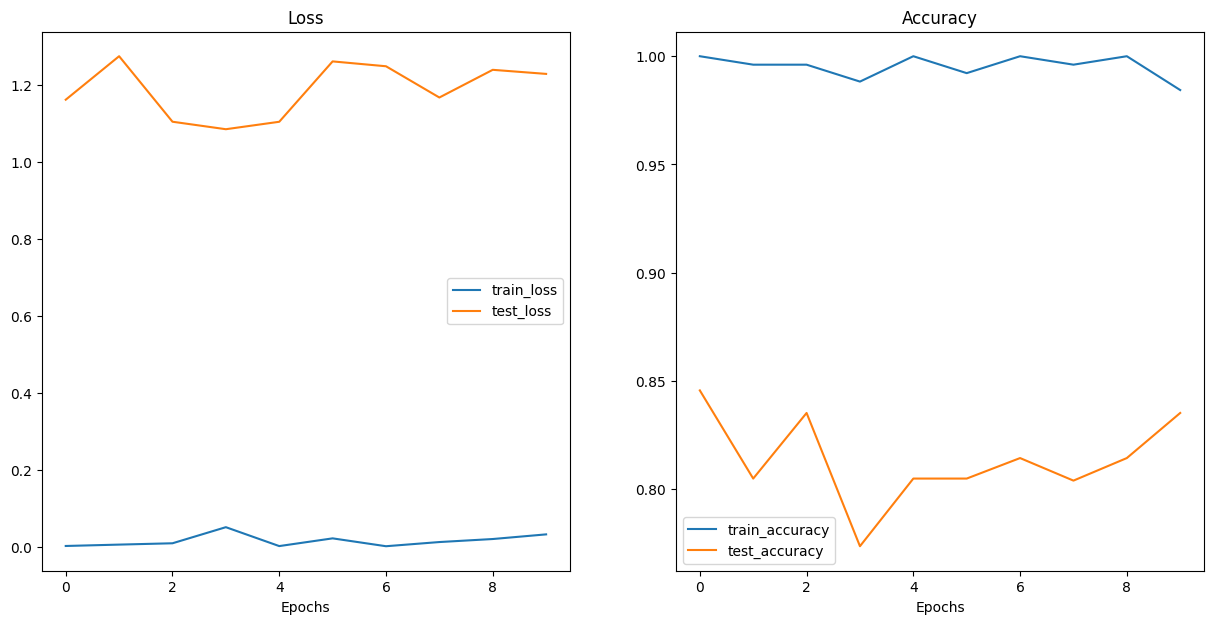

In [43]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

### Make Predictions

One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in the same format as the images our model was trained on. This means, we have to be sure that our images have:

- Same Shape
- Same Datatype
- Same Device
- Same Transformations

In [45]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

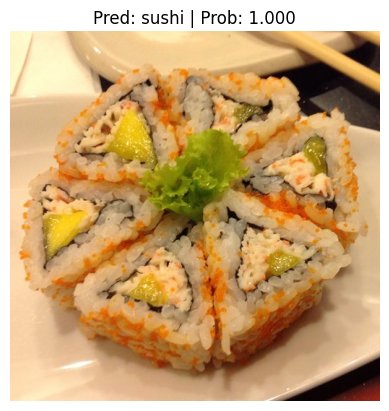

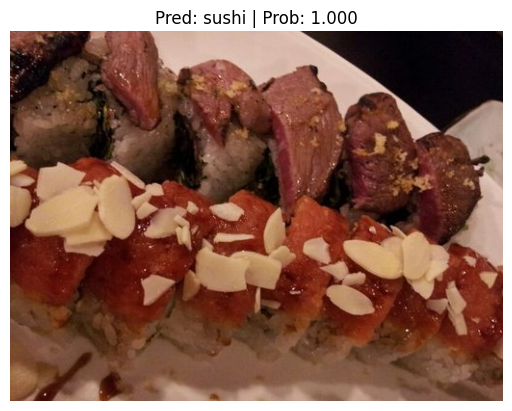

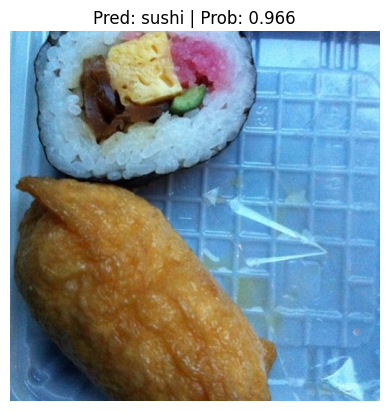

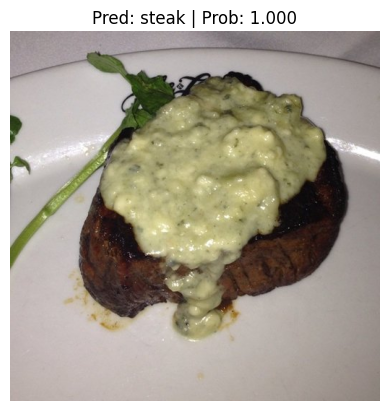

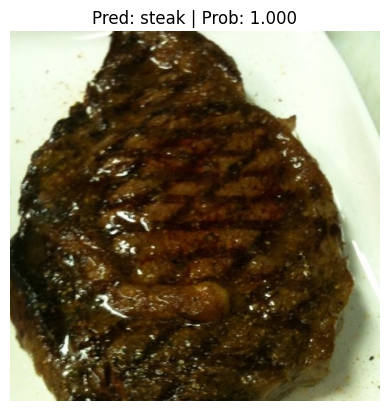

In [47]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 5
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

### Making Predicitons on Custom Image



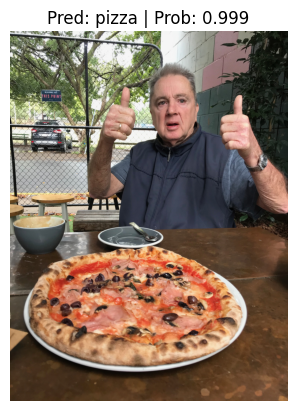

In [48]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

Now it got it right